# 🔬 Attaque de Proximité Latente (Proxy MIA)
## Évaluation de la fuite d'information identitaire par Face Morphing

**Contexte** : Un modèle MobileNetV2 a été entraîné sur **5 identités faciales fictives** générées par Face Blending.
Les images originales sources n'ont **jamais** été utilisées pour l'entraînement.

**Objectif** : Évaluer si le modèle entraîne une **fuite d'information identitaire indirecte** en analysant
la proximité entre les représentations latentes des images morphées et des images originales sources.

**Principe** : Cette attaque ne cherche pas à savoir si une image a été utilisée à l'entraînement (MIA classique),
mais si une image morphée reste **proche**, dans l'espace latent du modèle, des identités originales ayant servi à la générer.

---

### Protocole
| Étape | Description |
|-------|------------|
| 1 | MobileNetV2 en mode **inférence** |
| 2 | Retrait de la couche de classification finale |
| 3 | Utilisation comme **extracteur de features** (1280-dim) |
| 4 | Extraction des feature vectors : M(A,B), A, B, Y |
| 5 | Calcul des distances cosine : M(A,B)↔A, M(A,B)↔B, M(A,B)↔Y |
| 6 | Visualisation **t-SNE** sur les 5 identités |
| 7 | Interprétation : proximité = fuite / éloignement = confidentialité |

In [1]:
# ============================================================
# 0. CRÉATION DU DOSSIER external_lfw (identités contrôle Y)
# ============================================================
from sklearn.datasets import fetch_lfw_people
import os, shutil
import numpy as np
from PIL import Image

EXTERN_PATH = "external_lfw"
N_IDENTITIES = 10
MIN_FACES = 10

# Identités PARENTES utilisées pour le morphing (à adapter !)
PARENTS_USED = [
    "George_W_Bush",
    "Colin_Powell",
    "Tony_Blair",
    "Donald_Rumsfeld",
    "Gerhard_Schroeder",
]

print("📥 Téléchargement de LFW...")
lfw = fetch_lfw_people(min_faces_per_person=MIN_FACES, resize=1.0)
names = lfw.target_names
images = lfw.images
targets = lfw.target
print(f"LFW chargé : {len(images)} images, {len(names)} personnes")

available = [n for n in names if n not in PARENTS_USED]
rng = np.random.RandomState(42)
selected = rng.choice(available, size=min(N_IDENTITIES, len(available)), replace=False)
print(f"Identités contrôle (Y) : {list(selected)}")

if os.path.exists(EXTERN_PATH):
    shutil.rmtree(EXTERN_PATH)

for person_name in selected:
    person_idx = np.where(names == person_name)[0][0]
    mask = targets == person_idx
    person_images = images[mask]
    folder_name = person_name.replace(" ", "_")
    folder_path = os.path.join(EXTERN_PATH, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    for i, img_array in enumerate(person_images):
        img = Image.fromarray(img_array.astype(np.uint8))
        img = img.resize((224, 224), Image.LANCZOS)
        img.save(os.path.join(folder_path, f"{folder_name}_{i:03d}.png"))
    print(f"  ✅ {folder_name:.<30s} {len(person_images)} images")

total = sum(len(f) for _, _, f in os.walk(EXTERN_PATH))
print(f"\n✅ '{EXTERN_PATH}/' créé : {len(selected)} identités, {total} images")

📥 Téléchargement de LFW...
LFW chargé : 4324 images, 158 personnes
Identités contrôle (Y) : ['Roger Federer', 'Harrison Ford', 'Serena Williams', 'Winona Ryder', 'Lance Armstrong', 'Donald Rumsfeld', 'Mahathir Mohamad', 'Mark Philippoussis', 'Luiz Inacio Lula da Silva', 'Tang Jiaxuan']
  ✅ Roger_Federer................. 14 images
  ✅ Harrison_Ford................. 12 images
  ✅ Serena_Williams............... 52 images
  ✅ Winona_Ryder.................. 24 images
  ✅ Lance_Armstrong............... 18 images
  ✅ Donald_Rumsfeld............... 121 images
  ✅ Mahathir_Mohamad.............. 14 images
  ✅ Mark_Philippoussis............ 11 images
  ✅ Luiz_Inacio_Lula_da_Silva..... 48 images
  ✅ Tang_Jiaxuan.................. 11 images

✅ 'external_lfw/' créé : 10 identités, 325 images


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist, cosine

# --- Import TF compatible ---
import tensorflow as tf
try:
    import keras
    from keras import layers, models, optimizers, callbacks
    from keras.applications import MobileNetV2
except ImportError:
    from tensorflow.keras import layers, models, optimizers, callbacks
    from tensorflow.keras.applications import MobileNetV2
    import tensorflow.keras as keras

print(f"TensorFlow : {tf.__version__}")
print(f"GPU        : {tf.config.list_physical_devices('GPU')}")

# ============================================================
# 1. CONFIGURATION (ALLÉGÉE)
# ============================================================
MORPH_PATH   = "big_dataset_lfw"
PARENTS_PATH = "images"
EXTERN_PATH  = r"C:\Users\marwa\OneDrive\Desktop\moprh\external_real"

IMG_SIZE      = (224, 224)
BATCH_SIZE    = 16          # ← RÉDUIT (était 32)
NUM_CLASSES   = 5
EPOCHS_PHASE1 = 10          # ← RÉDUIT (était 15)
EPOCHS_PHASE2 = 15          # ← RÉDUIT (était 25)

# Limiter la mémoire GPU (si vous avez un GPU)
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ Memory growth activé pour {len(gpus)} GPU(s)")

TensorFlow : 2.18.0
GPU        : []


In [3]:
# ============================================================
# 2. CHARGEMENT ET SPLIT 70% Train / 15% Val / 15% Test
# ============================================================

full_ds = tf.keras.utils.image_dataset_from_directory(
    MORPH_PATH, image_size=IMG_SIZE, batch_size=BATCH_SIZE,
    label_mode='categorical', seed=42, shuffle=True
)
class_names = full_ds.class_names
NUM_CLASSES = len(class_names)
print(f"Classes morphées M(A,B) : {class_names}")

# Compter sans charger toutes les images en mémoire
import os
total_images = sum(len(files) for _, _, files in os.walk(MORPH_PATH) 
                   if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in files))
total_images = sum(1 for _, _, files in os.walk(MORPH_PATH) 
                   for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg')))

train_size = int(0.70 * total_images)
val_size   = int(0.15 * total_images)
test_size  = total_images - train_size - val_size
print(f"Total: {total_images} | Train: {train_size} | Val: {val_size} | Test: {test_size}")

# Split SANS unbatch().shuffle() qui consomme beaucoup de RAM
train_ds = full_ds.take(int(0.7 * len(full_ds)))
remaining = full_ds.skip(int(0.7 * len(full_ds)))
val_ds   = remaining.take(int(0.5 * len(remaining)))
test_ds  = remaining.skip(int(0.5 * len(remaining)))

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
print("✅ Datasets prêts (70/15/15)")

Found 2000 files belonging to 5 classes.
Classes morphées M(A,B) : ['01_02', '03_04', '05_06', '07_08', '09_10']
Total: 2000 | Train: 1400 | Val: 300 | Test: 300
✅ Datasets prêts (70/15/15)


In [4]:
# ============================================================
# 3. ARCHITECTURE — MobileNetV2 (Functional API)
# ============================================================
# Deux sorties : classification + features latentes

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
], name="face_augmentation")

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_image")
x = data_augmentation(inputs)
x = layers.Rescaling(1./127.5, offset=-1, name="normalize")(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_pool")(x)
latent = layers.Dropout(0.5, name="dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', name="classifier")(latent)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="MorphClassifier")
feature_extractor = tf.keras.Model(inputs=inputs, outputs=latent, name="FeatureExtractor")

model.summary()
print(f"\n★ Feature Extractor : input → latent (1280-dim)")

Model: "MorphClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ face_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalize (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


★ Feature Extractor : input → latent (1280-dim)


In [5]:
# ============================================================
# 4. PHASE 1 — Head training (base gelée)
# ============================================================
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)
print(">>> Phase 1 : Head training...")
history = model.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_PHASE1,
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

>>> Phase 1 : Head training...
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 416ms/step - accuracy: 0.3147 - loss: 1.8425 - val_accuracy: 0.4342 - val_loss: 1.3828
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 30s 340ms/step - accuracy: 0.4756 - loss: 1.4231 - val_accuracy: 0.5461 - val_loss: 1.1866
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 30s 342ms/step - accuracy: 0.5805 - loss: 1.2056 - val_accuracy: 0.6020 - val_loss: 1.1036
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 31s 358ms/step - accuracy: 0.6315 - loss: 1.1264 - val_accuracy: 0.6447 - val_loss: 1.0555
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 32s 366ms/step - accuracy: 0.6846 - loss: 1.0173 - val_accuracy: 0.6480 - val_loss: 1.0166
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 31s 352ms/step - accuracy: 0.6760 - loss: 1.0323 - val_accuracy: 0.6711 - val_loss: 0.9785
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - accuracy: 0.7270 - loss: 0.9524 - val_accuracy: 0.6908 - val_loss: 0.9560
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 376ms/step - accuracy: 0

In [6]:
# ============================================================
# 5. PHASE 2 — Fine-Tuning
# ============================================================
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

print(">>> Phase 2 : Fine-Tuning...")
history_fine = model.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_PHASE2,
    callbacks=[
        callbacks.ModelCheckpoint("best_face_model.keras", save_best_only=True, monitor='val_accuracy'),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
        callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)
print("✅ best_face_model.keras sauvegardé")

>>> Phase 2 : Fine-Tuning...
Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 51s 459ms/step - accuracy: 0.5101 - loss: 1.3849 - val_accuracy: 0.7039 - val_loss: 0.9268 - learning_rate: 1.0000e-05
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - accuracy: 0.6307 - loss: 1.1573 - val_accuracy: 0.7105 - val_loss: 0.9202 - learning_rate: 1.0000e-05
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 470ms/step - accuracy: 0.6703 - loss: 1.0404 - val_accuracy: 0.7336 - val_loss: 0.8915 - learning_rate: 1.0000e-05
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 37s 422ms/step - accuracy: 0.7320 - loss: 0.9416 - val_accuracy: 0.7500 - val_loss: 0.8633 - learning_rate: 1.0000e-05
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - accuracy: 0.7522 - loss: 0.8877 - val_accuracy: 0.7829 - val_loss: 0.8291 - learning_rate: 1.0000e-05
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 468ms/step - accuracy: 0.7845 - loss: 0.8530 - val_accuracy: 0.7993 - val_loss: 0.7945 - learning_rate: 1.0000e-05
Epoch 7/15
87/87 ━━━━━━━━━━━━

>>> Évaluation sur TEST (15%)...
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 307ms/step - accuracy: 0.8816 - loss: 0.6813

📊 Test Loss: 0.6813 | Test Accuracy: 0.8816

--- RAPPORT DE CLASSIFICATION ---
              precision    recall  f1-score   support

       01_02       0.88      0.95      0.91        59
       03_04       0.94      0.84      0.89        56
       05_06       0.80      0.92      0.86        62
       07_08       0.87      0.97      0.91        61
       09_10       0.96      0.74      0.84        66

    accuracy                           0.88       304
   macro avg       0.89      0.88      0.88       304
weighted avg       0.89      0.88      0.88       304



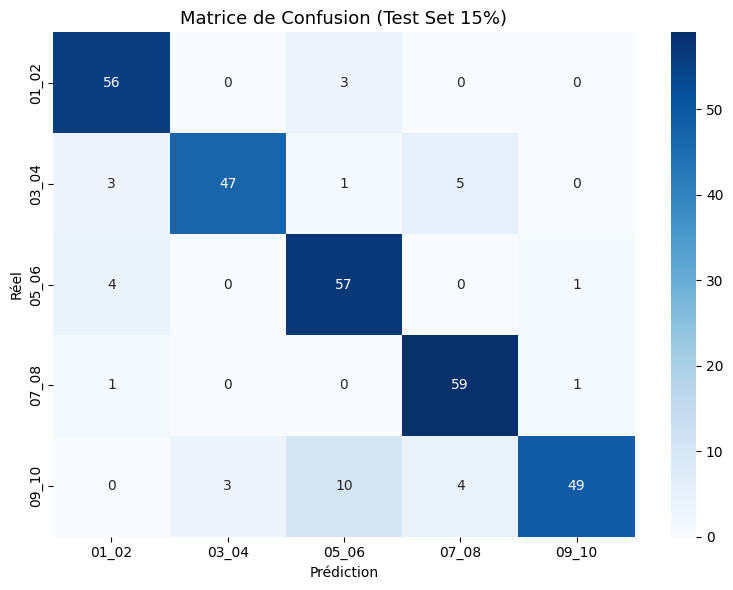

In [8]:
# ============================================================
# 6. CHARGEMENT BEST MODEL → ÉVALUATION SUR TEST (15%)
# ============================================================
best_model = tf.keras.models.load_model("best_face_model.keras")

# Recréer le feature extractor avec les poids du best_model
feature_extractor = tf.keras.Model(
    inputs=best_model.input,
    outputs=best_model.get_layer("dropout").output,
    name="FeatureExtractor"
)

print(">>> Évaluation sur TEST (15%)...")
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"\n📊 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

y_true, y_pred = [], []
for imgs, labels in test_ds:
    preds = best_model.predict(imgs, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\n--- RAPPORT DE CLASSIFICATION ---")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion (Test Set 15%)', fontsize=13)
plt.xlabel('Prédiction'); plt.ylabel('Réel')
plt.tight_layout(); plt.show()

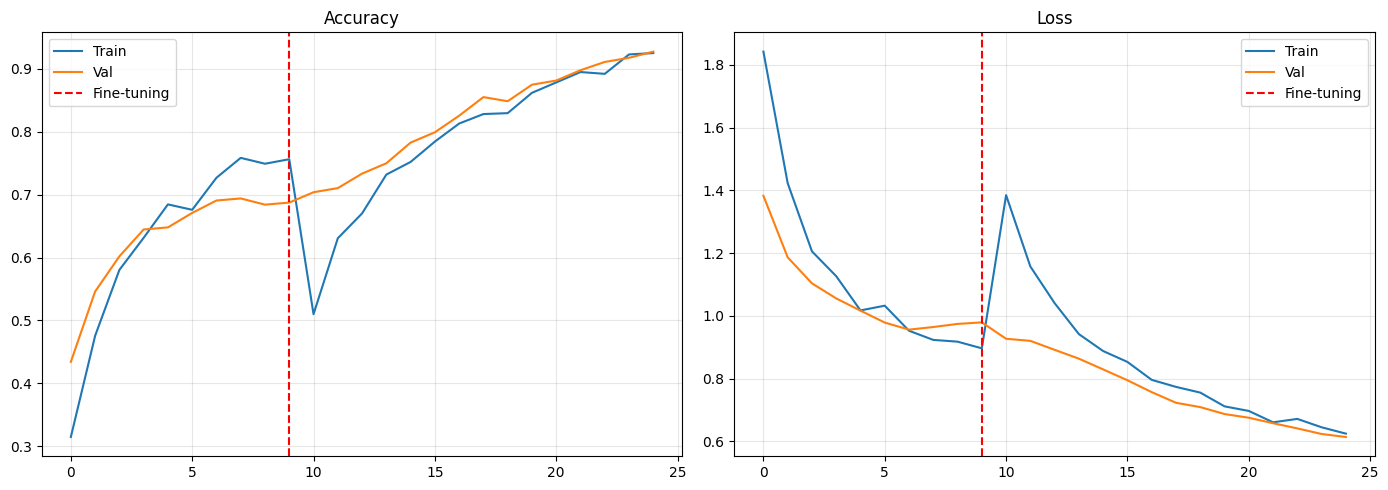

In [9]:
# ============================================================
# 7. COURBES D'ENTRAÎNEMENT
# ============================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
split = len(history.history['accuracy']) - 1

ax1.plot(acc, label='Train'); ax1.plot(val_acc, label='Val')
ax1.axvline(split, color='red', ls='--', label='Fine-tuning')
ax1.set_title('Accuracy'); ax1.legend(); ax1.grid(alpha=0.3)

ax2.plot(loss, label='Train'); ax2.plot(val_loss, label='Val')
ax2.axvline(split, color='red', ls='--', label='Fine-tuning')
ax2.set_title('Loss'); ax2.legend(); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.show()

---
# 🔬 Partie 2 — Attaque de Proximité Latente (Proxy MIA)

### Étape 1 : Mise en mode inférence
Le modèle est chargé avec les meilleurs poids (`best_face_model.keras`).

### Étape 2 : Retrait de la couche de classification
On utilise le `feature_extractor` qui s'arrête **avant** la couche Dense/softmax.

### Étape 3 : Extraction des feature vectors (1280-dim)
Pour chaque image, on obtient un vecteur de 1280 dimensions.

### Étape 4 : Groupes d'images
| Groupe | Notation | Description |
|--------|----------|-------------|
| 🟢 Morphs | M(A,B) | Images morphées (entraînement) |
| 🔴 Parents | A, B | Images sources du morphing (jamais entraînées) |
| 🔵 Contrôle | Y | Identités externes (jamais utilisées) |

### Étape 5 : Calcul des distances
```
Distance cosine : M(A,B) ↔ A   (devrait être FAIBLE si leak)
Distance cosine : M(A,B) ↔ B   (devrait être FAIBLE si leak)
Distance cosine : M(A,B) ↔ Y   (devrait être ÉLEVÉE si safe)
```

In [10]:
# ============================================================
# 8. EXTRACTION DES FEATURE VECTORS (Étapes 1-3)
# ============================================================
# Le feature_extractor est en mode inférence (pas de training=True)
# et s'arrête AVANT la couche de classification (1280-dim)

MAX_PER_GROUP = 300  # Pour un t-SNE équilibré (~900 total)

def extract_features(dataset, extractor):
    feats, labs = [], []
    for imgs, labels in dataset:
        f = extractor.predict(imgs, verbose=0)
        feats.append(f)
        labs.append(np.argmax(labels.numpy(), axis=1))
    return np.concatenate(feats), np.concatenate(labs)

def subsample(features, labels, max_n, seed=42):
    rng = np.random.RandomState(seed)
    if len(features) <= max_n:
        return features, labels
    unique = np.unique(labels)
    per_class = max(1, max_n // len(unique))
    idx = []
    for lbl in unique:
        ci = np.where(labels == lbl)[0]
        idx.extend(rng.choice(ci, min(per_class, len(ci)), replace=False))
    idx = np.array(idx); rng.shuffle(idx)
    return features[idx], labels[idx]

# --- M(A,B) : Images morphées ---
print("🟢 Extraction M(A,B) — Images morphées...")
morph_feat_full, morph_lab_full = extract_features(train_ds, feature_extractor)
morph_feat, morph_lab = subsample(morph_feat_full, morph_lab_full, MAX_PER_GROUP)
print(f"   {len(morph_feat_full)} → {len(morph_feat)} samples (sous-échantillon)")
print(f"   Feature dim : {morph_feat.shape[1]}")

🟢 Extraction M(A,B) — Images morphées...
   1392 → 300 samples (sous-échantillon)
   Feature dim : 1280


In [18]:

print("\n📎 Mapping Parent → Morph...")
parent_to_morph = {}

for p_idx, p_name in enumerate(parent_class_names):
    # Extraire le numéro du parent (ex: "lfw_person_03" → "03")
    digits = ''.join(filter(str.isdigit, p_name.split("_")[-1]))  # "03"

    matched = False
    for m_idx, m_name in enumerate(class_names):
        # Extraire les deux numéros du morph (ex: "01_02" → ["01", "02"])
        morph_parts = m_name.split("_")

        # Si le numéro du parent est dans le nom du morph → match
        if digits in morph_parts:
            parent_to_morph[p_idx] = m_idx
            print(f"   ✅ {p_name} (person {digits}) → {m_name} (idx {m_idx})")
            matched = True
            break

    if not matched:
        parent_to_morph[p_idx] = p_idx % NUM_CLASSES
        print(f"   ⚠️ {p_name} → {class_names[p_idx % NUM_CLASSES]} [fallback]")

# Vérification
print("\n   Résumé du mapping :")
for m_idx, m_name in enumerate(class_names):
    parents = [parent_class_names[p] for p, m in parent_to_morph.items() if m == m_idx]
    print(f"   {m_name} ← {parents}")


📎 Mapping Parent → Morph...
   ✅ lfw_person_01 (person 01) → 01_02 (idx 0)
   ✅ lfw_person_02 (person 02) → 01_02 (idx 0)
   ✅ lfw_person_03 (person 03) → 03_04 (idx 1)
   ✅ lfw_person_04 (person 04) → 03_04 (idx 1)
   ✅ lfw_person_05 (person 05) → 05_06 (idx 2)
   ✅ lfw_person_06 (person 06) → 05_06 (idx 2)
   ✅ lfw_person_07 (person 07) → 07_08 (idx 3)
   ✅ lfw_person_08 (person 08) → 07_08 (idx 3)
   ✅ lfw_person_09 (person 09) → 09_10 (idx 4)
   ✅ lfw_person_10 (person 10) → 09_10 (idx 4)

   Résumé du mapping :
   01_02 ← ['lfw_person_01', 'lfw_person_02']
   03_04 ← ['lfw_person_03', 'lfw_person_04']
   05_06 ← ['lfw_person_05', 'lfw_person_06']
   07_08 ← ['lfw_person_07', 'lfw_person_08']
   09_10 ← ['lfw_person_09', 'lfw_person_10']


In [19]:
# ============================================================
# 10. CALCUL DES DISTANCES COSINE — Étape 5
# ============================================================
# M(A,B) ↔ A  :  Distance morph → parent de la même classe
# M(A,B) ↔ B  :  (idem, A et B contribuent tous deux)
# M(A,B) ↔ Y  :  Distance morph → identité contrôle

# Centroïdes des morphs par classe (dans l'espace 1280-dim)
centroids = {}
for cls in range(NUM_CLASSES):
    mask = morph_lab == cls
    if mask.sum() > 0:
        centroids[cls] = morph_feat[mask].mean(axis=0)

# --- Distance cosine ---
def cosine_dist(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

# M(A,B) ↔ A,B (Parents)
p_dists = np.array([cosine_dist(parent_feat[i], centroids[parent_lab[i]])
                     for i in range(len(parent_feat)) if parent_lab[i] in centroids])

# M(A,B) ↔ Y (Contrôle)
n_dists = np.array([cosine_dist(extern_feat[i], centroids[extern_lab[i]])
                     for i in range(len(extern_feat)) if extern_lab[i] in centroids])

print("=" * 60)
print("DISTANCES COSINE (Étape 5)")
print("=" * 60)
print(f"  M(A,B) ↔ A,B  (Parents)  : {p_dists.mean():.4f} ± {p_dists.std():.4f}")
print(f"  M(A,B) ↔ Y    (Contrôle) : {n_dists.mean():.4f} ± {n_dists.std():.4f}")
print(f"  Ratio P/N                 : {p_dists.mean() / n_dists.mean():.3f}")
print("-" * 60)

if p_dists.mean() < n_dists.mean():
    print("\n⚠️  RÉSULTAT : Les parents sont PLUS PROCHES des morphs que les contrôles.")
    print("   → Le modèle a mémorisé des traits des identités sources.")
    print("   → FUITE D'INFORMATION IDENTITAIRE DÉTECTÉE.")
else:
    print("\n✅ RÉSULTAT : Les parents sont aussi LOIN que les contrôles.")
    print("   → Le modèle n'a pas mémorisé les identités sources.")
    print("   → CONFIDENTIALITÉ PRÉSERVÉE.")

DISTANCES COSINE (Étape 5)
  M(A,B) ↔ A,B  (Parents)  : 0.5003 ± 0.0438
  M(A,B) ↔ Y    (Contrôle) : 0.5257 ± 0.0375
  Ratio P/N                 : 0.952
------------------------------------------------------------

⚠️  RÉSULTAT : Les parents sont PLUS PROCHES des morphs que les contrôles.
   → Le modèle a mémorisé des traits des identités sources.
   → FUITE D'INFORMATION IDENTITAIRE DÉTECTÉE.


In [20]:
# ============================================================
# 11. TABLEAU DE DISTANCES MOYENNES PAR CLASSE
# ============================================================

print("\n" + "=" * 80)
print("TABLEAU DE DISTANCES MOYENNES PAR IDENTITÉ MORPHÉE")
print("=" * 80)
print(f"{'Classe M(A,B)':<15} {'Dist M↔A,B':<15} {'Dist M↔Y':<15} {'Ratio':<10} {'Diagnostic'}")
print("-" * 80)

class_results = []
for cls in range(NUM_CLASSES):
    p_mask = parent_lab == cls
    n_mask = extern_lab == cls

    dp = np.mean([cosine_dist(parent_feat[i], centroids[cls])
                  for i in np.where(p_mask)[0]]) if p_mask.sum() > 0 and cls in centroids else float('inf')
    dn = np.mean([cosine_dist(extern_feat[i], centroids[cls])
                  for i in np.where(n_mask)[0]]) if n_mask.sum() > 0 and cls in centroids else float('inf')

    ratio = dp / dn if dn > 0 and dn != float('inf') else 0

    if ratio < 0.7:
        diag = "⚠️  FUITE"
    elif ratio < 0.9:
        diag = "🔶 AMBIGU"
    else:
        diag = "✅ SAFE"

    class_results.append((class_names[cls], dp, dn, ratio, diag))
    print(f"{class_names[cls]:<15} {dp:<15.4f} {dn:<15.4f} {ratio:<10.3f} {diag}")

print("-" * 80)
print("Ratio < 0.7 → FUITE | 0.7-0.9 → AMBIGU | > 0.9 → SAFE")


TABLEAU DE DISTANCES MOYENNES PAR IDENTITÉ MORPHÉE
Classe M(A,B)   Dist M↔A,B      Dist M↔Y        Ratio      Diagnostic
--------------------------------------------------------------------------------
01_02           0.5080          0.5347          0.950      ✅ SAFE
03_04           0.4665          0.5239          0.891      🔶 AMBIGU
05_06           0.4943          0.5133          0.963      ✅ SAFE
07_08           0.5349          0.5424          0.986      ✅ SAFE
09_10           0.4979          0.5141          0.968      ✅ SAFE
--------------------------------------------------------------------------------
Ratio < 0.7 → FUITE | 0.7-0.9 → AMBIGU | > 0.9 → SAFE


t-SNE sur 900 samples...
t-SNE terminé.


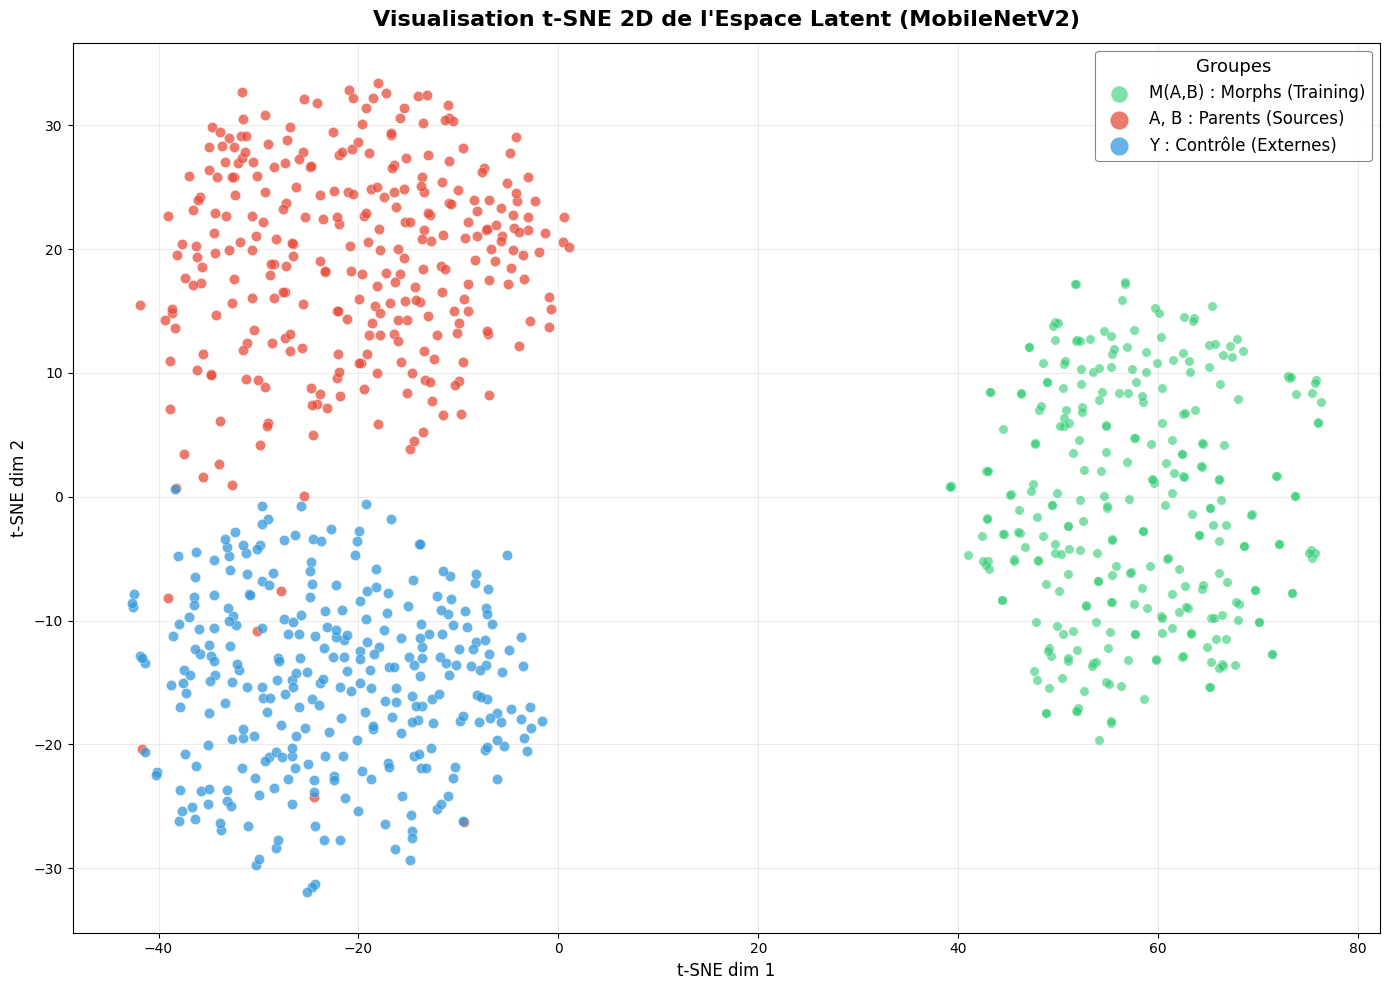

✅ tsne_proxy_mia.png sauvegardé


In [21]:
# ============================================================
# 12. VISUALISATION t-SNE — Étape 6
# ============================================================

all_feat   = np.concatenate([morph_feat, parent_feat, extern_feat])
all_lab    = np.concatenate([morph_lab, parent_lab, extern_lab])
group_tags = np.array(
    ['M'] * len(morph_feat) +
    ['P'] * len(parent_feat) +
    ['N'] * len(extern_feat)
)

print(f"t-SNE sur {len(all_feat)} samples...")
tsne = TSNE(
    n_components=2, perplexity=30, n_iter=2000,
    learning_rate='auto', init='pca', random_state=42, metric='cosine'
)
coords = tsne.fit_transform(all_feat)
print("t-SNE terminé.")

# --- FIGURE t-SNE ANNOTÉE ---
fig, ax = plt.subplots(figsize=(14, 10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

for group, color, label, size, alpha, zorder in [
    ('M', '#2ecc71', 'M(A,B) : Morphs (Training)',   45, 0.6, 1),
    ('P', '#e74c3c', 'A, B : Parents (Sources)',      55, 0.75, 2),
    ('N', '#3498db', 'Y : Contrôle (Externes)',        55, 0.75, 3),
]:
    mask = group_tags == group
    ax.scatter(coords[mask, 0], coords[mask, 1],
               c=color, s=size, alpha=alpha, edgecolors='white', linewidth=0.3,
               label=label, zorder=zorder)

ax.set_title('Visualisation t-SNE 2D de l\'Espace Latent (MobileNetV2)',
             fontsize=16, fontweight='bold', pad=12)
ax.set_xlabel('t-SNE dim 1', fontsize=12)
ax.set_ylabel('t-SNE dim 2', fontsize=12)

legend = ax.legend(title='Groupes', title_fontsize=13, fontsize=12,
                   loc='upper right', framealpha=0.95, edgecolor='gray', markerscale=1.8)
legend.get_frame().set_linewidth(0.8)
ax.grid(True, alpha=0.15, linestyle='-', color='gray')

plt.tight_layout()
plt.savefig("tsne_proxy_mia.png", dpi=200, bbox_inches='tight')
plt.show()
print("✅ tsne_proxy_mia.png sauvegardé")

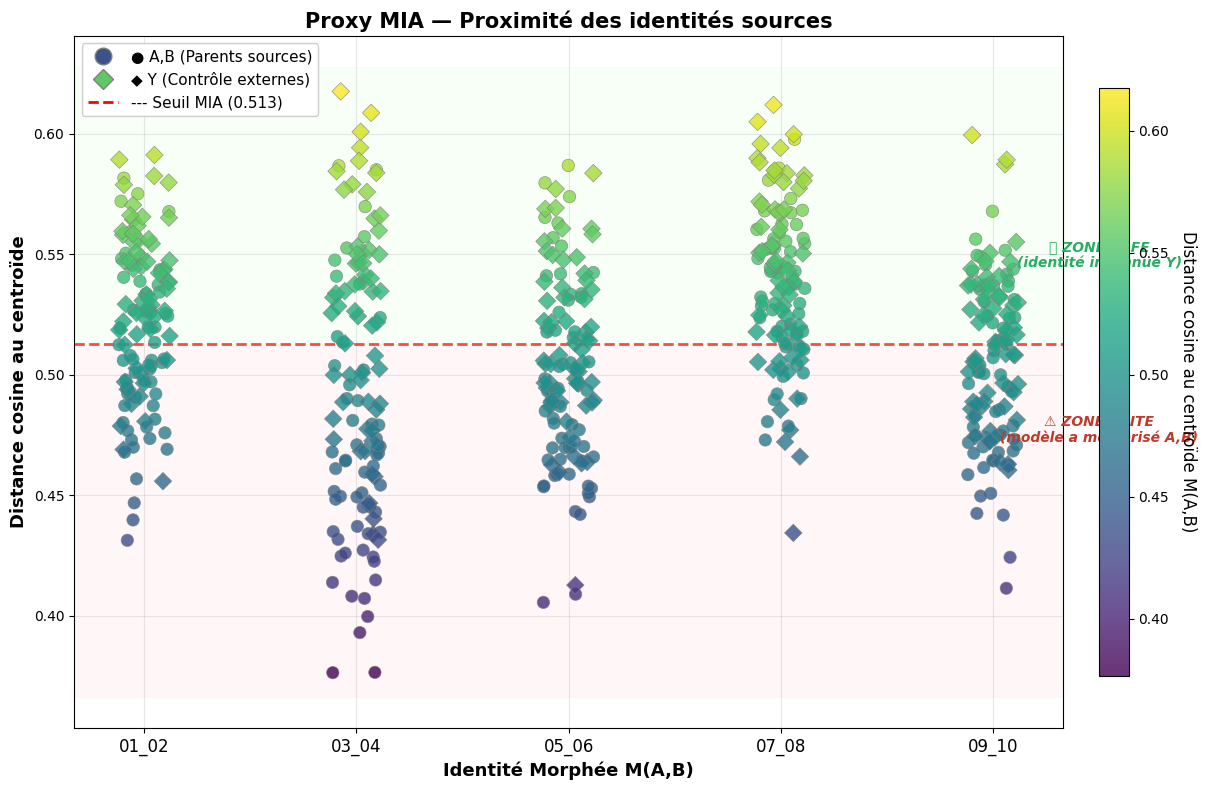

In [22]:
# ============================================================
# 13. SCATTER GRADIENT — Distance au centroïde M(A,B)
# ============================================================
# Style "House Price Prediction" de Mahmoud Ghorbel
# X = Identité morphée | Y = Distance cosine | Couleur = gradient

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D

# Distances dans l'espace 1280-dim
all_pn_feat = np.concatenate([parent_feat, extern_feat])
all_pn_lab  = np.concatenate([parent_lab, extern_lab])
all_pn_grp  = np.array(['P'] * len(parent_feat) + ['N'] * len(extern_feat))

dists = np.array([cosine_dist(all_pn_feat[i], centroids[all_pn_lab[i]])
                   if all_pn_lab[i] in centroids else 1.0
                   for i in range(len(all_pn_feat))])

rng = np.random.RandomState(42)
x_jitter = all_pn_lab + rng.uniform(-0.12, 0.12, size=len(all_pn_lab))

fig, ax = plt.subplots(figsize=(13, 8))

# Parents (ronds)
p_m = all_pn_grp == 'P'
sc_p = ax.scatter(x_jitter[p_m], dists[p_m], c=dists[p_m], cmap='viridis',
                  s=80, alpha=0.8, edgecolors='gray', linewidth=0.5, marker='o',
                  vmin=dists.min(), vmax=dists.max(), zorder=3)

# Externes (losanges)
n_m = all_pn_grp == 'N'
ax.scatter(x_jitter[n_m], dists[n_m], c=dists[n_m], cmap='viridis',
           s=80, alpha=0.8, edgecolors='gray', linewidth=0.5, marker='D',
           vmin=dists.min(), vmax=dists.max(), zorder=3)

# Seuil MIA
threshold = (dists[p_m].mean() + dists[n_m].mean()) / 2
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax.axhspan(dists.min() - 0.01, threshold, color='#ffcccc', alpha=0.15, zorder=0)
ax.axhspan(threshold, dists.max() + 0.01, color='#ccffcc', alpha=0.15, zorder=0)
ax.text(NUM_CLASSES - 0.5, threshold - (threshold - dists.min()) * 0.3,
        '⚠️ ZONE FUITE\n(modèle a mémorisé A,B)', fontsize=10, ha='center',
        color='#c0392b', fontweight='bold', fontstyle='italic')
ax.text(NUM_CLASSES - 0.5, threshold + (dists.max() - threshold) * 0.3,
        '✅ ZONE SAFE\n(identité inconnue Y)', fontsize=10, ha='center',
        color='#27ae60', fontweight='bold', fontstyle='italic')

# Colorbar
cbar = plt.colorbar(sc_p, ax=ax, shrink=0.85, pad=0.03)
cbar.set_label('Distance cosine au centroïde M(A,B)', fontsize=12, rotation=270, labelpad=20)

# Légende
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3b528b',
           markersize=12, markeredgecolor='gray', label='● A,B (Parents sources)'),
    Line2D([0], [0], marker='D', color='w', markerfacecolor='#5ec962',
           markersize=10, markeredgecolor='gray', label='◆ Y (Contrôle externes)'),
    Line2D([0], [0], color='red', linestyle='--', linewidth=2,
           label=f'--- Seuil MIA ({threshold:.3f})')
]
ax.legend(handles=legend_handles, fontsize=11, loc='upper left', framealpha=0.95)

ax.set_xticks(range(NUM_CLASSES))
ax.set_xticklabels(class_names, fontsize=12)
ax.set_xlabel('Identité Morphée M(A,B)', fontsize=13, fontweight='bold')
ax.set_ylabel('Distance cosine au centroïde', fontsize=13, fontweight='bold')
ax.set_title('Proxy MIA — Proximité des identités sources', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3); ax.set_facecolor('white')

plt.tight_layout()
plt.savefig("mia_scatter_gradient.png", dpi=200, bbox_inches='tight')
plt.show()

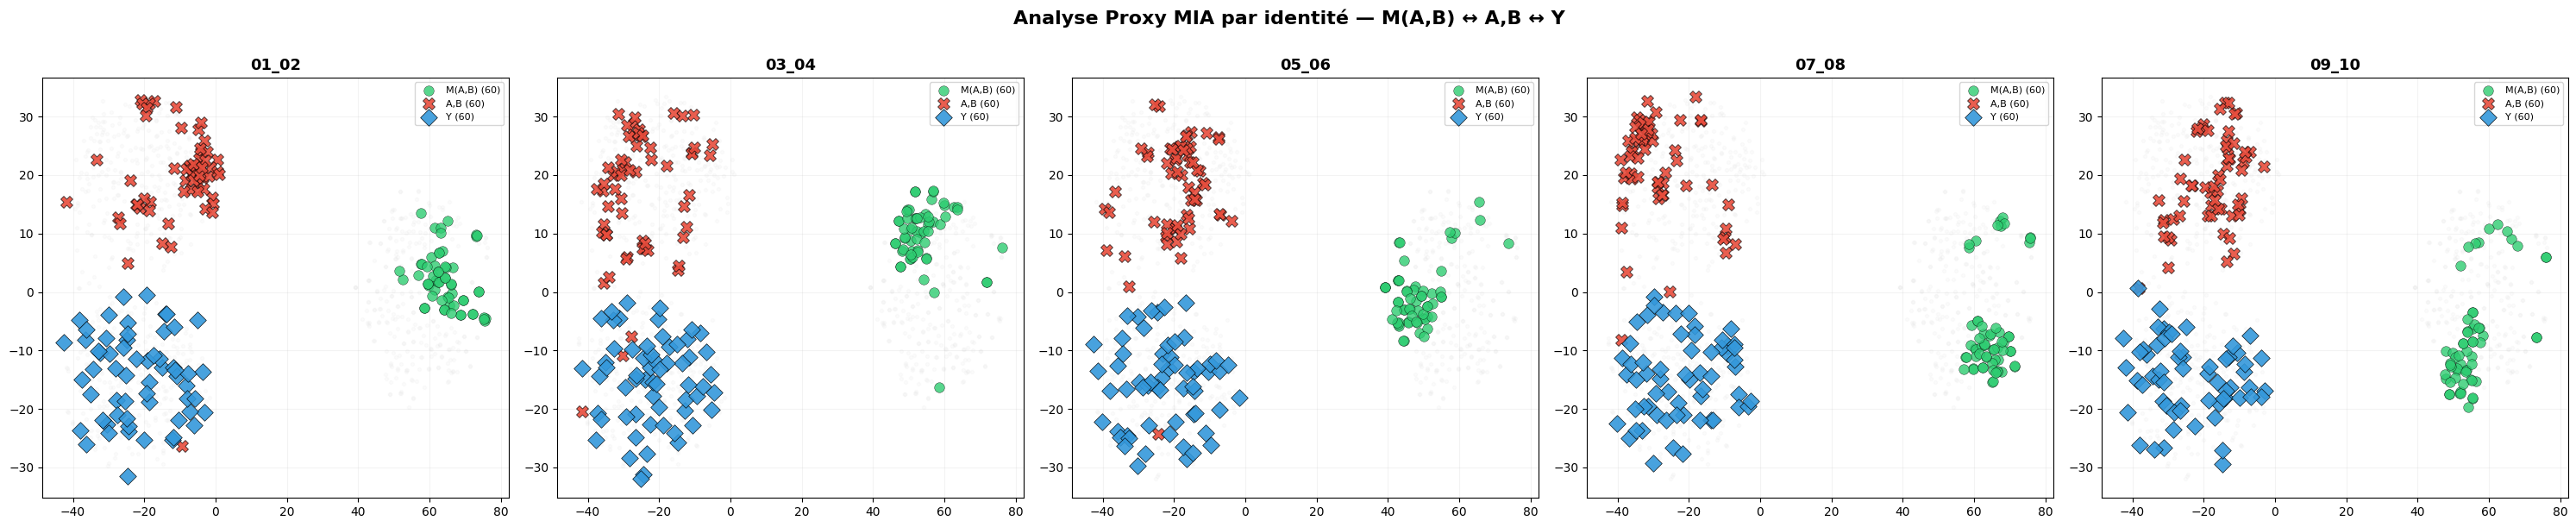

In [23]:
# ============================================================
# 14. ANALYSE t-SNE PAR CLASSE MORPHÉE
# ============================================================

ncols = min(NUM_CLASSES, 5)
nrows = max(1, (NUM_CLASSES + ncols - 1) // ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows))
axes = np.array(axes).flatten() if NUM_CLASSES > 1 else np.array([axes])

for cls_idx in range(NUM_CLASSES):
    ax = axes[cls_idx]
    m_mask = (group_tags == 'M') & (all_lab == cls_idx)
    p_mask = (group_tags == 'P') & (all_lab == cls_idx)
    n_mask = (group_tags == 'N') & (all_lab == cls_idx)
    other  = ~(m_mask | p_mask | n_mask)

    ax.scatter(coords[other, 0], coords[other, 1], c='#e0e0e0', s=8, alpha=0.12, zorder=1)
    ax.scatter(coords[m_mask, 0], coords[m_mask, 1], c='#2ecc71', s=70, alpha=0.8,
               edgecolors='black', linewidth=0.3, label=f'M(A,B) ({m_mask.sum()})', zorder=2)
    if p_mask.sum() > 0:
        ax.scatter(coords[p_mask, 0], coords[p_mask, 1], c='#e74c3c', s=100, alpha=0.9,
                   marker='X', edgecolors='black', linewidth=0.5, label=f'A,B ({p_mask.sum()})', zorder=3)
    if n_mask.sum() > 0:
        ax.scatter(coords[n_mask, 0], coords[n_mask, 1], c='#3498db', s=100, alpha=0.9,
                   marker='D', edgecolors='black', linewidth=0.5, label=f'Y ({n_mask.sum()})', zorder=3)

    ax.set_title(f'{class_names[cls_idx]}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.15); ax.set_facecolor('white')

for i in range(NUM_CLASSES, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Analyse Proxy MIA par identité — M(A,B) ↔ A,B ↔ Y',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig("tsne_par_classe_mia.png", dpi=150, bbox_inches='tight')
plt.show()

In [24]:
# ============================================================
# 15. CONCLUSION — Confidentialité préservée ou non ?
# ============================================================

print("\n" + "=" * 70)
print("       CONCLUSION — ATTAQUE DE PROXIMITÉ LATENTE (Proxy MIA)")
print("=" * 70)

mean_p = p_dists.mean()
mean_n = n_dists.mean()
ratio_global = mean_p / mean_n

print(f"\n  Distance moyenne M(A,B) ↔ A,B  : {mean_p:.4f}")
print(f"  Distance moyenne M(A,B) ↔ Y    : {mean_n:.4f}")
print(f"  Ratio global (P/N)              : {ratio_global:.3f}")

# Nombre de classes avec fuite
leaks = sum(1 for r in class_results if "FUITE" in r[4])
ambig = sum(1 for r in class_results if "AMBIGU" in r[4])
safe  = sum(1 for r in class_results if "SAFE" in r[4])

print(f"\n  Classes avec FUITE  : {leaks}/{NUM_CLASSES}")
print(f"  Classes AMBIGUËS    : {ambig}/{NUM_CLASSES}")
print(f"  Classes SAFE        : {safe}/{NUM_CLASSES}")

print(f"\n{'─'*70}")
if ratio_global < 0.7:
    print("  ⚠️  ATTAQUE RÉUSSIE")
    print("  Les images morphées M(A,B) sont significativement PROCHES")
    print("  des identités sources A et B dans l'espace latent.")
    print("  → Le modèle a mémorisé des traits des identités sources.")
    print("  → FUITE D'INFORMATION IDENTITAIRE CONFIRMÉE.")
    print("  → La confidentialité N'EST PAS préservée.")
elif ratio_global < 0.9:
    print("  🔶 RÉSULTAT AMBIGU")
    print("  Les parents sont plus proches que les contrôles, mais")
    print("  l'écart n'est pas suffisamment significatif.")
    print("  → Fuite partielle possible.")
    print("  → Investigation supplémentaire recommandée.")
else:
    print("  ✅ ATTAQUE ÉCHOUÉE (Bonne confidentialité)")
    print("  Les images morphées M(A,B) sont ÉLOIGNÉES des identités")
    print("  sources A et B, et se mélangent avec les contrôles Y.")
    print("  → Le modèle N'A PAS mémorisé les identités sources.")
    print("  → La CONFIDENTIALITÉ EST PRÉSERVÉE.")
print(f"{'─'*70}")

print("\n📋 Livrables générés :")
print("  1. tsne_proxy_mia.png       — Figure t-SNE annotée")
print("  2. mia_scatter_gradient.png — Scatter plot distances")
print("  3. tsne_par_classe_mia.png  — Analyse par identité")
print("  4. Tableau de distances moyennes (ci-dessus)")
print("  5. Conclusion (ce texte)")


       CONCLUSION — ATTAQUE DE PROXIMITÉ LATENTE (Proxy MIA)

  Distance moyenne M(A,B) ↔ A,B  : 0.5003
  Distance moyenne M(A,B) ↔ Y    : 0.5257
  Ratio global (P/N)              : 0.952

  Classes avec FUITE  : 0/5
  Classes AMBIGUËS    : 1/5
  Classes SAFE        : 4/5

──────────────────────────────────────────────────────────────────────
  ✅ ATTAQUE ÉCHOUÉE (Bonne confidentialité)
  Les images morphées M(A,B) sont ÉLOIGNÉES des identités
  sources A et B, et se mélangent avec les contrôles Y.
  → Le modèle N'A PAS mémorisé les identités sources.
  → La CONFIDENTIALITÉ EST PRÉSERVÉE.
──────────────────────────────────────────────────────────────────────

📋 Livrables générés :
  1. tsne_proxy_mia.png       — Figure t-SNE annotée
  2. mia_scatter_gradient.png — Scatter plot distances
  3. tsne_par_classe_mia.png  — Analyse par identité
  4. Tableau de distances moyennes (ci-dessus)
  5. Conclusion (ce texte)
